In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from collections import namedtuple
import jax
import jax.numpy as jnp
import genjax
from src.genjax_distributions import (
    uniform_discrete, uniform_pose,
    uniform_choice, contact_params_uniform
)

In [5]:
ObjectInfo = namedtuple("ObjectInfo", ["parent_obj", "parent_face", "child_face", "category_index", "pose", "params"])
def empty_object_info():
    return ObjectInfo(
        jnp.array(-1),
        jnp.array(-1),
        jnp.array(-1),
        jnp.array(-1),
        jnp.nan * jnp.zeros((4, 4)),
        jnp.nan * jnp.zeros(3)
    )
        

@genjax.static_gen_fn
def generate_object(
    object_idx : int,
    possible_category_indices,
    pose_bounds,
    contact_bounds,
    all_box_dims
):
    i = object_idx
    parent_obj = uniform_discrete(-1, object_idx) @ f"parent_{i}"
    parent_face = uniform_discrete(0, 6) @ f"face_parent_{i}"
    child_face = uniform_discrete(0, 6) @ f"face_child_{i}"
    category_index = uniform_choice(possible_category_indices) @ f"category_{i}"
    
    pose = (
            uniform_pose(
                pose_bounds[0],
                pose_bounds[1],
            )
            @ f"root_pose_{i}"
        )

    params = (
        contact_params_uniform(contact_bounds[0], contact_bounds[1])
        @ f"contact_params_{i}"
    )

    return ObjectInfo(parent_obj, parent_face, child_face, category_index, pose, params)

In [6]:
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
pose_bounds = jnp.array([-jnp.ones(3)*100.0, jnp.ones(3)*100.0])
contact_bounds = jnp.array([jnp.array([-12.0, -12.0, -jnp.pi]), jnp.array([12.0, 12.0, jnp.pi])])
all_box_dims = None
args = (0, jnp.arange(5), pose_bounds, contact_bounds, all_box_dims)
trace = generate_object.simulate(key, args)
trace.get_retval()

ObjectInfo(parent_obj=Array(-1, dtype=int32), parent_face=Array(0, dtype=int32), child_face=Array(2, dtype=int32), category_index=Array(1, dtype=int32), pose=Array([[ 2.1296251e-01,  8.5993189e-01,  4.6385771e-01, -7.2911598e+01],
       [ 1.1613947e-01,  4.4910288e-01, -8.8589954e-01, -5.0466324e+01],
       [-9.7013324e-01,  2.4253568e-01, -4.2299628e-03, -6.5908836e+01],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],      dtype=float32), params=Array([-2.178543  , -0.42150593,  1.5729983 ], dtype=float32))

In [7]:
import jax.experimental.checkify as checkify
console = genjax.console(enforce_checkify=True)

## Q: why is err appearing either way??:

In [8]:
masked = genjax.masking_combinator(generate_object)
trace = masked.simulate(key, (jnp.array(True), args))
err, val = checkify.checkify(trace.get_retval().unmask)()
console.print(err)
console.print(val)

Error(_pred={}, _code={}, _metadata={}, _payload={})

ObjectInfo(
    parent_obj=Array(-1, dtype=int32),
    parent_face=Array(0, dtype=int32),
    child_face=Array(2, dtype=int32),
    category_index=Array(1, dtype=int32),
    pose=Array([[ 2.1296251e-01,  8.5993189e-01,  4.6385771e-01, -7.2911598e+01],
       [ 1.1613947e-01,  4.4910288e-01, -8.8589954e-01, -5.0466324e+01],
       [-9.7013324e-01,  2.4253568e-01, -4.2299628e-03, -6.5908836e+01],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],      dtype=float32),
    params=Array([-2.178543  , -0.42150593,  1.5729983 ], dtype=float32)
)

In [9]:
trace = masked.simulate(key, (jnp.array(True), args))
trace.get_retval().match(lambda: empty_object_info(), lambda x: x)

ObjectInfo(parent_obj=Array(-1, dtype=int32, weak_type=True), parent_face=Array(0, dtype=int32, weak_type=True), child_face=Array(2, dtype=int32, weak_type=True), category_index=Array(1, dtype=int32, weak_type=True), pose=Array([[ 2.1296251e-01,  8.5993189e-01,  4.6385771e-01, -7.2911598e+01],
       [ 1.1613947e-01,  4.4910288e-01, -8.8589954e-01, -5.0466324e+01],
       [-9.7013324e-01,  2.4253568e-01, -4.2299628e-03, -6.5908836e+01],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],      dtype=float32), params=Array([-2.178543  , -0.42150593,  1.5729983 ], dtype=float32))

In [10]:
trace = masked.simulate(key, (jnp.array(False), args))
trace.get_retval().match(lambda: empty_object_info(), lambda x: x)

ObjectInfo(parent_obj=Array(-1, dtype=int32, weak_type=True), parent_face=Array(-1, dtype=int32, weak_type=True), child_face=Array(-1, dtype=int32, weak_type=True), category_index=Array(-1, dtype=int32, weak_type=True), pose=Array([[nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan]], dtype=float32), params=Array([nan, nan, nan], dtype=float32))

In [11]:
object_indices = jnp.arange(5)
possible_object_categories = jnp.tile(jnp.arange(4), (5, 1))
pose_boundss = jnp.tile(pose_bounds, (5, 1, 1))
contact_boundss = jnp.tile(contact_bounds, (5, 1, 1))
all_box_dimss = jnp.nan * jnp.ones(5)
argss = (object_indices, possible_object_categories, pose_boundss, contact_boundss, all_box_dimss)

In [12]:
mapped = genjax.map_combinator(in_axes=(0,0,0,0,0))(generate_object)
trace = mapped.simulate(key, argss)
trace.get_retval()

ObjectInfo(parent_obj=Array([-1,  0,  0,  1,  0], dtype=int32), parent_face=Array([0, 4, 2, 1, 4], dtype=int32), child_face=Array([5, 2, 2, 2, 2], dtype=int32), category_index=Array([1, 1, 3, 3, 3], dtype=int32), pose=Array([[[ 5.2901769e-01,  1.5356764e-02, -8.4847188e-01, -7.7767326e+01],
        [ 4.1145980e-01,  8.6980534e-01,  2.7228582e-01, -7.5854752e+01],
        [ 7.4218678e-01, -4.9315608e-01,  4.5382369e-01,  5.0380249e+01],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],

       [[-8.9460647e-01,  3.6910450e-01,  2.5187510e-01, -3.6411644e+01],
        [-8.8158533e-02,  4.0679872e-01, -9.0925395e-01,  7.7249695e+01],
        [-4.3807226e-01, -8.3562946e-01, -3.3138514e-01, -9.2919067e+01],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],

       [[-5.4967666e-01,  2.1887279e-01,  8.0619496e-01, -2.7153946e+01],
        [ 8.2270801e-01, -2.5605798e-02,  5.6788731e-01, -1.5467682e+00],
        [ 1.4493835e-01,  9.7541738e-0

In [13]:
empty_iterated = jax.vmap(empty_object_info, axis_size=5)()
empty_iterated

ObjectInfo(parent_obj=Array([-1, -1, -1, -1, -1], dtype=int32, weak_type=True), parent_face=Array([-1, -1, -1, -1, -1], dtype=int32, weak_type=True), child_face=Array([-1, -1, -1, -1, -1], dtype=int32, weak_type=True), category_index=Array([-1, -1, -1, -1, -1], dtype=int32, weak_type=True), pose=Array([[[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]]], dtype=float32), params=Array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]

In [14]:
xval = empty_object_info()
xxval = jax.vmap(empty_object_info, axis_size=5)()
mapped_masked = genjax.map_combinator(in_axes=(0, (0,0,0,0,0)))(masked)
trace = mapped_masked.simulate(key, (jnp.tile(jnp.array(True), (5,)), argss))
trace.get_retval().match(lambda: xxval, lambda x: x)

TypeError: Value ObjectInfo(parent_obj=Traced<ShapedArray(int32[5], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>, parent_face=Traced<ShapedArray(int32[5], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>, child_face=Traced<ShapedArray(int32[5], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>, category_index=Traced<ShapedArray(int32[5], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>, pose=Traced<ShapedArray(float32[5,4,4])>with<DynamicJaxprTrace(level=1/0)>, params=Traced<ShapedArray(float32[5,3])>with<DynamicJaxprTrace(level=1/0)>) with type <class '__main__.ObjectInfo'> is not a valid JAX type

In [15]:
rv = trace.get_retval()
flag = jnp.array(rv.mask)
jax.lax.select(
    flag,
    (lambda x : x)(rv.value),
    (lambda: xxval)()
)

TypeError: Value ObjectInfo(parent_obj=Traced<ShapedArray(int32[5], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>, parent_face=Traced<ShapedArray(int32[5], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>, child_face=Traced<ShapedArray(int32[5], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>, category_index=Traced<ShapedArray(int32[5], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>, pose=Traced<ShapedArray(float32[5,4,4])>with<DynamicJaxprTrace(level=1/0)>, params=Traced<ShapedArray(float32[5,3])>with<DynamicJaxprTrace(level=1/0)>) with type <class '__main__.ObjectInfo'> is not a valid JAX type

In [42]:
# From ChatGPT
def select_elements(cond, a, b):
    """
    Select elements from a or b based on the condition.

    Args:
    cond (array): A 1D array of boolean values with length equal to the size of the first dimension of a and b.
    a (array): An array of any shape, but its first dimension must be the same size as cond.
    b (array): An array of the same shape as a.

    Returns:
    array: An array of the same shape as a and b, with elements selected from a or b based on cond.
    """
    # Reshape cond to be broadcastable with a and b
    new_shape = (-1,) + (1,) * (a.ndim - 1)
    cond_broadcasted = cond.reshape(new_shape)

    # Use jnp.where to select elements
    return jnp.where(cond_broadcasted, a, b)

def mymatch(masked, none, some):
    flag = jnp.array(masked.mask)
    sel_fn = lambda x, y : select_elements(flag, x, y)
    return jax.tree_util.tree_map(sel_fn, some(masked.value), none())

trace = mapped_masked.simulate(key, (jnp.tile(jnp.array(False), (5,)), argss))
mymatch(trace.get_retval(), lambda: jax.vmap(empty_object_info, axis_size=5)(), lambda x: x)

ObjectInfo(parent_obj=Array([-1, -1, -1, -1, -1], dtype=int32), parent_face=Array([-1, -1, -1, -1, -1], dtype=int32), child_face=Array([-1, -1, -1, -1, -1], dtype=int32), category_index=Array([-1, -1, -1, -1, -1], dtype=int32), pose=Array([[[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]]], dtype=float32), params=Array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]], dtype=float32

In [ ]:
Say 

In [28]:
flag[:, None, None].shape

(5, 1, 1)

In [24]:
a = jax.random.uniform(key, (5, 3))
b = jax.random.uniform(key, (5, 3))
cond = jax.random.bernoulli(key, 0.5, (5,))
result = jnp.where(cond[:, None], a, b)

In [31]:
x

HierarchicalChoiceMap(
  trie=Trie(inner={'a': Trie(inner={'b': ChoiceValue(value=5)})})
)

In [28]:
Point = namedtuple("Point", ["x", "y"])

Point(jnp.arange(5), jnp.arange(5))

Point(x=Array([0, 1, 2, 3, 4], dtype=int32), y=Array([0, 1, 2, 3, 4], dtype=int32))

In [30]:
ar = jnp.array([Point(x, y) for x, y in zip(jnp.arange(5), jnp.arange(5))])
ar[0]

Array([0, 0], dtype=int32)

In [25]:
(lambda: xxval)()

ObjectInfo(parent_obj=Array([-1, -1, -1, -1, -1], dtype=int32, weak_type=True), parent_face=Array([-1, -1, -1, -1, -1], dtype=int32, weak_type=True), child_face=Array([-1, -1, -1, -1, -1], dtype=int32, weak_type=True), category_index=Array([-1, -1, -1, -1, -1], dtype=int32, weak_type=True), pose=Array([[[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]]], dtype=float32), params=Array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]

In [13]:
trace.get_retval()

Mask(
  mask=bool[5],
  value=ObjectInfo(
    parent_obj=i32[5],
    parent_face=i32[5],
    child_face=i32[5],
    category_index=i32[5],
    pose=f32[5,4,4],
    params=f32[5,3]
  )
)

In [15]:
genjax.Mask(jnp.tile(jnp.array((True)), (5)), jax.vmap(empty_object_info, axis_size=5)())

Mask(
  mask=bool[5],
  value=ObjectInfo(
    parent_obj=i32[5],
    parent_face=i32[5],
    child_face=i32[5],
    category_index=i32[5],
    pose=f32[5,4,4],
    params=f32[5,3]
  )
)

In [147]:
trace.get_retval().unmask()

ObjectInfo(parent_obj=Array([-1,  0,  0,  1,  0], dtype=int32), parent_face=Array([0, 4, 2, 1, 4], dtype=int32), child_face=Array([5, 2, 2, 2, 2], dtype=int32), category_index=Array([1, 1, 3, 3, 3], dtype=int32), pose=Array([[[ 5.2901769e-01,  1.5356764e-02, -8.4847188e-01, -7.7767326e+01],
        [ 4.1145980e-01,  8.6980534e-01,  2.7228582e-01, -7.5854752e+01],
        [ 7.4218678e-01, -4.9315608e-01,  4.5382369e-01,  5.0380249e+01],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],

       [[-8.9460647e-01,  3.6910450e-01,  2.5187510e-01, -3.6411644e+01],
        [-8.8158533e-02,  4.0679872e-01, -9.0925395e-01,  7.7249695e+01],
        [-4.3807226e-01, -8.3562946e-01, -3.3138514e-01, -9.2919067e+01],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],

       [[-5.4967666e-01,  2.1887279e-01,  8.0619496e-01, -2.7153946e+01],
        [ 8.2270801e-01, -2.5605798e-02,  5.6788731e-01, -1.5467682e+00],
        [ 1.4493835e-01,  9.7541738e-0

In [141]:
jax.vmap(empty_object_info, axis_size=5)()

ObjectInfo(parent_obj=Array([-1, -1, -1, -1, -1], dtype=int32, weak_type=True), parent_face=Array([-1, -1, -1, -1, -1], dtype=int32, weak_type=True), child_face=Array([-1, -1, -1, -1, -1], dtype=int32, weak_type=True), category_index=Array([-1, -1, -1, -1, -1], dtype=int32, weak_type=True), pose=Array([[[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]]], dtype=float32), params=Array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]

In [143]:
trace.get_retval().unmask()

ObjectInfo(parent_obj=Array([-1,  0,  0,  1,  0], dtype=int32), parent_face=Array([0, 4, 2, 1, 4], dtype=int32), child_face=Array([5, 2, 2, 2, 2], dtype=int32), category_index=Array([1, 1, 3, 3, 3], dtype=int32), pose=Array([[[ 5.2901769e-01,  1.5356764e-02, -8.4847188e-01, -7.7767326e+01],
        [ 4.1145980e-01,  8.6980534e-01,  2.7228582e-01, -7.5854752e+01],
        [ 7.4218678e-01, -4.9315608e-01,  4.5382369e-01,  5.0380249e+01],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],

       [[-8.9460647e-01,  3.6910450e-01,  2.5187510e-01, -3.6411644e+01],
        [-8.8158533e-02,  4.0679872e-01, -9.0925395e-01,  7.7249695e+01],
        [-4.3807226e-01, -8.3562946e-01, -3.3138514e-01, -9.2919067e+01],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],

       [[-5.4967666e-01,  2.1887279e-01,  8.0619496e-01, -2.7153946e+01],
        [ 8.2270801e-01, -2.5605798e-02,  5.6788731e-01, -1.5467682e+00],
        [ 1.4493835e-01,  9.7541738e-0

In [150]:
trace = mapped.simulate(key, argss)
category_indices = trace.get_retval().category_index
category_indices

Array([1, 1, 3, 3, 3], dtype=int32)

In [151]:
import bayes3d as b

In [152]:
r = trace.get_retval()
box_dims = jnp.tile(jnp.ones(3), (4, 1))
poses = b.scene_graph.poses_from_scene_graph(
    r.pose,
    box_dims,
    r.parent_obj,
    r.params,
    r.parent_face,
    r.child_face
)
poses

Array([[[ 5.2901769e-01,  1.5356764e-02, -8.4847188e-01, -7.7767326e+01],
        [ 4.1145980e-01,  8.6980534e-01,  2.7228582e-01, -7.5854752e+01],
        [ 7.4218678e-01, -4.9315608e-01,  4.5382369e-01,  5.0380249e+01],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],

       [[-3.2403937e-01, -7.8430778e-01,  5.2901769e-01, -7.8048645e+01],
        [ 9.0626264e-01, -9.6894860e-02,  4.1145986e-01, -6.9916824e+01],
        [-2.7145207e-01,  6.1275822e-01,  7.4218673e-01,  4.5941475e+01],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],

       [[ 5.2792960e-01, -3.7228465e-02,  8.4847176e-01, -7.5978165e+01],
        [ 3.7512448e-01, -8.8608235e-01, -2.7228576e-01, -6.7079628e+01],
        [ 7.6195282e-01,  4.6203038e-01, -4.5382375e-01,  5.0663860e+01],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],

       [[ 1.1924115e-01, -6.0880446e-01, -7.8430772e-01, -7.7672638e+01],
        [ 9.4576442e-01,  3.1006

set up bayes3d so I can play with the renderer a bit...

In [154]:
import pickle
import glob
import os
with open('../data.pkl', 'rb') as f:
    data = pickle.load(f)

camera_image_1 = data["init"][0]
categories_on_table = data["init"][1]
target_category = data["init"][2]
table_info = data["init"][3] # table pose and dimensions
n_objects = 5

X_WT = b.t3d.pybullet_pose_to_transform(table_info[0])
X_WC = b.t3d.pybullet_pose_to_transform(camera_image_1["camera_pose"])
X_CT = b.t3d.inverse_pose(X_WC) @ X_WT

def image_to_rgbd(camera_image_1):
    K = camera_image_1['camera_matrix']
    rgb = camera_image_1['rgbPixels']
    depth = camera_image_1['depthPixels']
    camera_pose = camera_image_1['camera_pose']
    camera_pose = b.t3d.pybullet_pose_to_transform(camera_pose)
    fx, fy, cx, cy = K[0,0],K[1,1],K[0,2],K[1,2]
    h,w = depth.shape
    rgbd_original = b.RGBD(rgb, depth, camera_pose, b.Intrinsics(h,w,fx,fy,cx,cy,0.001,10000.0))
    return rgbd_original

rgbd_original = image_to_rgbd(camera_image_1)
print("Got rgbd_original")

scaling_factor = 0.2
rgbd_scaled_down = b.RGBD.scale_rgbd(rgbd_original, scaling_factor)
print("Got rgb immage scaled down.")

b.setup_renderer(rgbd_scaled_down.intrinsics)

# os.path.join(os.path.abspath(''), 'bayes3d/assets/bop/ycbv/models')# 
model_dir = os.path.join(os.path.abspath('../..'), 'bayes3d/assets/bop/ycbv/models')
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(13+1).rjust(6, '0') + ".ply")
ycb_filenames = glob.glob(os.path.join(model_dir, "*.ply"))
ycb_index_order = [int(s.split("/")[-1].split("_")[-1].split(".")[0]) for s in ycb_filenames]
sorted_ycb_filenames = [s for _,s in sorted(zip(ycb_index_order, ycb_filenames))]

relevant_objects = [any(x in name for x in categories_on_table) for (i, name) in enumerate(b.utils.ycb_loader.MODEL_NAMES)]
relevant_object_names = [b.utils.ycb_loader.MODEL_NAMES[i] for i in range(len(b.utils.ycb_loader.MODEL_NAMES)) if relevant_objects[i]]
filtered_filenames = [sorted_ycb_filenames[i] for i in range(len(sorted_ycb_filenames)) if relevant_objects[i]]

table_dims = table_info[1:]
table_mesh = b.utils.make_cuboid_mesh(table_dims)
b.RENDERER.add_mesh(table_mesh, "table")
print("Added table mesh.")

pillar_mesh = b.utils.make_cuboid_mesh(jnp.array([0.02, 0.02, 0.5]))
b.RENDERER.add_mesh(pillar_mesh, "pillar")
print("Added pillar mesh.")

for model_path in filtered_filenames:
    b.RENDERER.add_mesh_from_file(model_path, scaling_factor=1.0/1000.0)
    print(f"Added mesh at path {model_path}.")

Got rgbd_original
Got rgb immage scaled down.


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (64, 64, 1024)
Added table mesh.
Added pillar mesh.
Added mesh at path /home/georgematheos/bayes3d/assets/bop/ycbv/models/obj_000002.ply.
Added mesh at path /home/georgematheos/bayes3d/assets/bop/ycbv/models/obj_000003.ply.
Added mesh at path /home/georgematheos/bayes3d/assets/bop/ycbv/models/obj_000011.ply.
Added mesh at path /home/georgematheos/bayes3d/assets/bop/ycbv/models/obj_000013.ply.
Added mesh at path /home/georgematheos/bayes3d/assets/bop/ycbv/models/obj_000021.ply.


In [175]:
r.category_index

Array([1, 1, 3, 3, 3], dtype=int32)

In [155]:
r = trace.get_retval()
box_dims = b.RENDERER.model_box_dims
poses = b.scene_graph.poses_from_scene_graph(
    r.pose,
    box_dims,
    r.parent_obj,
    r.params,
    r.parent_face,
    r.child_face
)
poses

Array([[[ 5.2901769e-01,  1.5356764e-02, -8.4847188e-01, -7.7767326e+01],
        [ 4.1145980e-01,  8.6980534e-01,  2.7228582e-01, -7.5854752e+01],
        [ 7.4218678e-01, -4.9315608e-01,  4.5382369e-01,  5.0380249e+01],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],

       [[-3.2403937e-01, -7.8430778e-01,  5.2901769e-01, -7.7850266e+01],
        [ 9.0626264e-01, -9.6894860e-02,  4.1145986e-01, -6.9762527e+01],
        [-2.7145207e-01,  6.1275822e-01,  7.4218673e-01,  4.6219795e+01],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],

       [[ 5.2792960e-01, -3.7228465e-02,  8.4847176e-01, -7.5232986e+01],
        [ 3.7512448e-01, -8.8608235e-01, -2.7228576e-01, -6.7318764e+01],
        [ 7.6195282e-01,  4.6203038e-01, -4.5382375e-01,  5.0265285e+01],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],

       [[ 1.1924115e-01, -6.0880446e-01, -7.8430772e-01, -7.8181702e+01],
        [ 9.4576442e-01,  3.1006

In [171]:
camera_pose = uniform_pose.sample(key, pose_bounds[0], pose_bounds[1])

In [177]:
rendered = b.RENDERER.render(jnp.linalg.inv(camera_pose) @ poses, -1 * jnp.ones(5, dtype=int))[..., :3]
rendered[:, :, 0]

Array([[-12152.381, -11771.429, -11390.477, ...,  11085.715,  11466.668,
         11847.62 ],
       [-12152.381, -11771.429, -11390.477, ...,  11085.715,  11466.668,
         11847.62 ],
       [-12152.381, -11771.429, -11390.477, ...,  11085.715,  11466.668,
         11847.62 ],
       ...,
       [-12152.381, -11771.429, -11390.477, ...,  11085.715,  11466.668,
         11847.62 ],
       [-12152.381, -11771.429, -11390.477, ...,  11085.715,  11466.668,
         11847.62 ],
       [-12152.381, -11771.429, -11390.477, ...,  11085.715,  11466.668,
         11847.62 ]], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


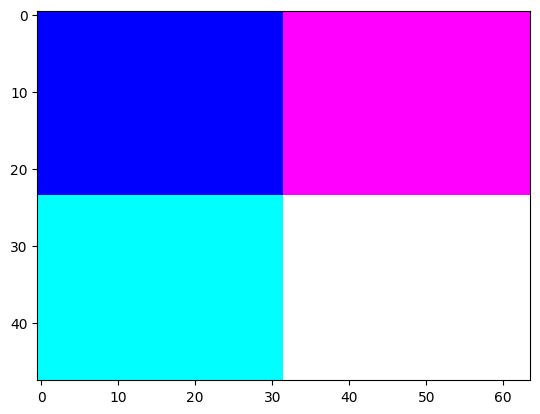

In [173]:
import matplotlib.pyplot as plt
plt.imshow(rendered)